# Set up Environment

In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import copy
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [40]:
combined = sc.read('/scratch/qc_filtered_combined_samples.h5ad')

# Select the Cells of Interest

#### Before any further analysis we will exclude the cells that are neither CD8+ nor TCR+. First select the TCR and CD8 genes. #### Even though drop-out events are possible, it is extremely unlikely if drop-outs happen simultaneous for all 160 genes of a single cell. So by doing this we are almost 100% confident that we are subsetting all the T-cells, especially all of the CD8 T-cells

In [41]:
selected_genes = combined.var_names.str.startswith(("TRAV","TRAJ","TRBV","TRBD","TRBJ","CD8A","CD8B"))
CD8_related_genes = set(combined[:,selected_genes].var_names)

In [42]:
print("There are {} genes selected".format(len(CD8_related_genes)))

There are 160 genes selected


In [43]:
kept_cells = combined[:,'CD8A'].X>0
for gene in set(CD8_related_genes):
    kept_cells = kept_cells + (combined[:,gene].X>0)

In [44]:
# Now abusing the notation ( we again call it "combined" so that we don't have to change the rest of the code), we subset 
# the cells using the genes 
combined = combined[kept_cells,:]

# Select Important and Highly Variable Genes

#### Find highly variable features/genes that will also provide a good separation of the cell types and cell clusters.

Trying to set attribute `.uns` of view, copying.


Highly variable genes: 500


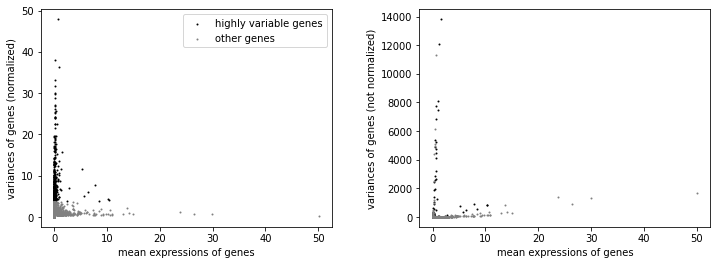

In [45]:
# compute variable genes
sc.pp.highly_variable_genes(combined, flavor='seurat_v3',n_top_genes=500)
print("Highly variable genes: {}".format(sum(combined.var.highly_variable)))

# plot variable genes
sc.pl.highly_variable_genes(combined)

CD62L,L-selectin: 'SELL', CD45: 'PTPRC', CD95:'FAS'

In [46]:
important_marker_genes = ['CD8A','CD8B','PTPRC','TBX21','CCR5','CXCR3','IL7','SELL','GATA3','CCR6','IL4','GZMB',
                          'PRF1','IL2RB','IL2RA','FOXP3','CD28','IL10','CD44','EOMES','IL17A','IL17B','IL17C','IL10','CD69'
                          'CD27','FAS','KLRG1','CCR7','GZMA','GZMH','GZMK','GZMM','GNYL','ENTPD1','TCF7','ITGAE','CTSW', 
                          'IFNG','CD161','TNFRSF4','TNFRSF18','NKG7','B3GAT1']

In [47]:
important_nonmarker_genes = ['CD4','CD68','CD163','MS4A2','CD14','CD16','XCL2','COL1A2','MMP2','ACTA2','CD79A',
                             'LAMP3','TPSAB1','PECAM1']

PD-1: 'PDCD1', TIM3:'HAVCR2'

In [48]:
exhaustion_markers = ['CXCL13','CTLA4','PDCD1','HAVCR2','TIGIT','BTLA','CD244','CD160','ICOS','LAG3']

CD137:'TNFRSF9', KI67:'MKI67'

In [49]:
proliferation_markers = ['TOP2A','MKI67','TNFRSF9'] 

In [50]:
#HLA_class1_genes = combined.var_names.str.startswith(('HLA-A','HLA-B','HLA-C','HLA-E','HLA-F','HLA-G'))
#HLA_class2_genes = combined.var_names.str.startswith(('HLA-DM','HLA-DQ','HLA-DO','HLA-DP','HLA-DR'))
#HLA_class1_genes = list(combined[:,HLA_class1_genes].var_names)
#HLA_class2_genes = list(combined[:,HLA_class2_genes].var_names)

In [51]:
important_genes = important_marker_genes + important_nonmarker_genes+exhaustion_markers+proliferation_markers

In [52]:
# filter out the TCR genes in case their idiosyncrasy skews the clustering 
selected = list(combined.var_names.str.startswith(("TRA","TRB","HLA")))
TCR_genes = set(combined[:,selected].var_names)
for gene in TCR_genes:
    combined.var['highly_variable'][gene] = False

In [53]:
# restore the genes in case they are filtered out, all genes (including top 200 and the important markers 
# are stored as highly variable)
for gene in important_genes:
    combined.var['highly_variable'][gene] = True

In [54]:
# combined.raw stores a scopy of the data at current stage
# we do this since we will trim genes and only use the top few hundreds for clustering, yet we want to retain all genes for
# differential expression purposes

In [55]:
combined.raw = combined
combined = combined[:, combined.var['highly_variable']]

## PCA

In [56]:
# Extract cell cycle genes 
cell_cycle_genes = [x.strip() for x in open('/work/cell_cycle_genes.txt')]

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in combined.var_names]

In [57]:
# compute gene scores for cell cycle genes which we will regress out
sc.tl.score_genes_cell_cycle(combined, s_genes=s_genes, g2m_genes=g2m_genes)

Trying to set attribute `.obs` of view, copying.


... storing 'phase' as categorical


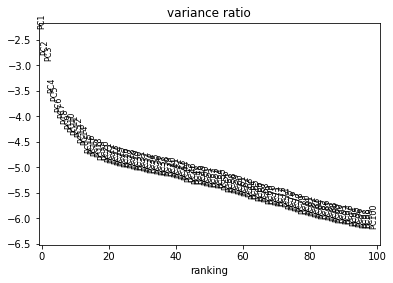

In [58]:
# regress out effects of total counts per cell and scale genes to have unit variance
sc.pp.regress_out(combined, ['total_counts', 'S_score', 'G2M_score'])
sc.pp.scale(combined, zero_center=False, max_value=10)

sc.tl.pca(combined, svd_solver='arpack',n_comps=100,use_highly_variable=True)
sc.pl.pca_variance_ratio(combined, log=True, n_pcs = 100)

In [59]:
save_file = '/scratch/PCA_decomposed_combined_samples.h5ad'
combined.write_h5ad(save_file)

# Dimension Reduction by Manifold Embedding

## UMAP without Batch Correction

In [60]:
combined1 = copy.deepcopy(combined)

In [61]:
# compute neighbor graph
# the choice of n_pcs=35 is determined by sensiticity analysis on n_pcs
# for more details of choosing n_pcs, see part5_Sensitivity_Analysis_on_PC_Num
sc.pp.neighbors(combined1, n_neighbors=10, n_pcs=35)

In [62]:
# compute umap projection
uncorrected_umap = sc.tl.umap(combined1, n_components=2, copy=True,min_dist=0.05)
# Leiden clustering
sc.tl.leiden(uncorrected_umap)

In [63]:
# save file before we rank genes (by differential expression) for cluster identification
# we will rank genes in two-ways: with selected top genes and with all genes
save_file = '/scratch/uncorrected_umap.h5ad'
uncorrected_umap.write_h5ad(save_file)

## UMAP with Batch Correction

In [64]:
# bbknn is a batch correction algorithm that also computes neighbor graph (two birds with one stone)
sc.external.pp.bbknn(combined, batch_key='bat', n_pcs=30)

In [65]:
# project to a 2-dimensional subspace, save to a new object so that the umap with 2D is not overwritten.
batch_corrected_umap = sc.tl.umap(combined, n_components=2, copy=True,min_dist=0.05)

In [66]:
# Leiden clustering
sc.tl.leiden(batch_corrected_umap)
# find marker genes
sc.tl.rank_genes_groups(batch_corrected_umap, groupby='leiden',method='wilcoxon')

In [ ]:
# save file 
save_file = '/scratch/batch_corrected_umap.h5ad'
batch_corrected_umap.write_h5ad(save_file)

## Exporting PCA and UMAP Represented Data Matrix 

#### Extract cluster from specific trajectories

In [16]:
batch_corrected_umap = sc.read('/scratch/batch_corrected_umap.h5ad')
# defining the trajectory of interest
trajectory = ['1','11','9','12','8','18','7','0','17','5']

# subsetting cells
trajectory_cells = batch_corrected_umap.obs['leiden']==trajectory[0]
for cluster in trajectory:
    trajectory_cells += (batch_corrected_umap.obs['leiden']==cluster)
trajectory_cells = batch_corrected_umap[trajectory_cells,:]

Trying to set attribute `.uns` of view, copying.


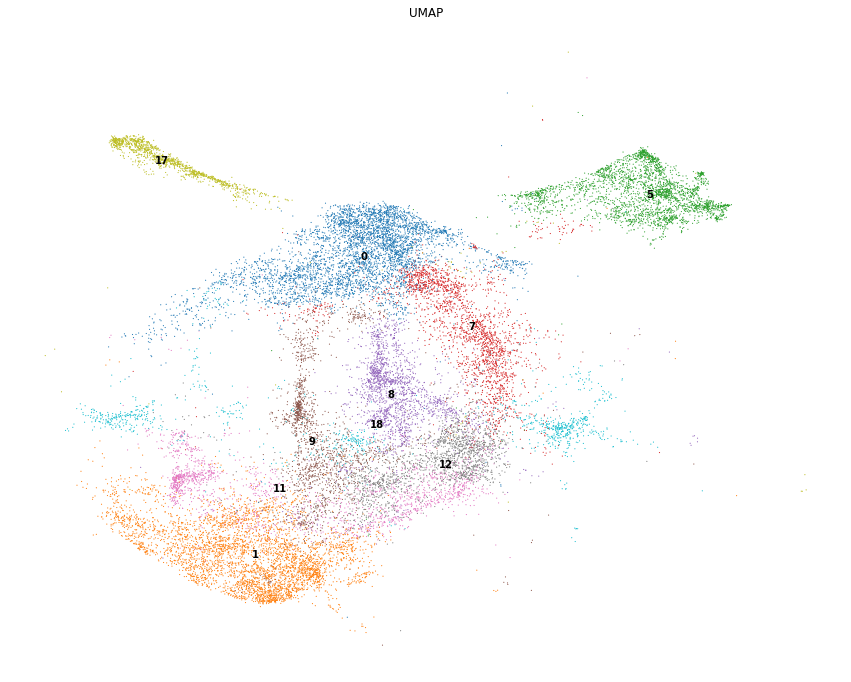

In [17]:
fig, ax = plt.subplots(figsize=(15,12))
sc.pl.umap(trajectory_cells, color='leiden', title='UMAP', legend_loc='on data',frameon=False,ax=ax)

In [18]:
UMAP_coordinates = pd.DataFrame(trajectory_cells.obsm['X_umap'])
UMAP_coordinates.columns = ['UMAP_'+str(i) for i in range(len(UMAP_coordinates.columns))]
UMAP_coordinates['cluster'] = trajectory_cells.obs['leiden'].tolist()
UMAP_coordinates.index = trajectory_cells.obs.index
UMAP_coordinates = UMAP_coordinates.transpose()

In [19]:
UMAP_coordinates.to_csv('/scratch/UMAP_coordinates.csv')

#### Export PCA coordinates

In [39]:
# extract PCA matrix from the scanpy data object and make cells into columns and coordinates into rows
PCA_matrix = pd.DataFrame(trajectory_cells.obsm['X_pca'].T)
# change the coordinate names into PC_k
PCA_matrix.index = ['PC_'+str(i) for i in range(1,len(trajectory_cells.obsm['X_pca'][0])+1)]
# change cell names into cell_i
PCA_matrix.columns = trajectory_cells.obs.index
# extract umap cluster assignment for each cell and make into a dataframe
umap_cluster = trajectory_cells.obs['leiden'].T.tolist()
umap_cluster = pd.DataFrame([umap_cluster],columns=PCA_matrix.columns)
umap_cluster.index = ['cluster']
# merge umap assignment into PCA data frame
PCA_matrix = PCA_matrix.append(umap_cluster)

In [40]:
PCA_matrix

,ACGAGCCCAGGATTGG-1-0,ATCATCTAGGAGTACC-1-0,ATCCACCGTCCTAGCG-1-0,ATTCTACGTAAGGGAA-1-0,ATTCTACTCAGATAAG-1-0,CAAGGCCAGCCAGTTT-1-0,CACATTTTCGTAGATC-1-0,CAGGTGCCAGCGATCC-1-0,CATTCGCCATCATCCC-1-0,CGATTGACACAGGCCT-1-0,...,TTTGCGCTCTCCGGTT-1-18,TTTGGTTTCACCGTAA-1-18,TTTGGTTTCAGCCTAA-1-18,TTTGGTTTCCGGGTGT-1-18,TTTGGTTTCTAACTGG-1-18,TTTGTCAAGCGGCTTC-1-18,TTTGTCACAAGCCTAT-1-18,TTTGTCAGTCCAAGTT-1-18,TTTGTCAGTGCGAAAC-1-18,TTTGTCAGTGGCTCCA-1-18
PC_1,0.46915,0.860131,1.88896,2.62167,-0.122396,0.390585,0.298877,1.15674,-0.039467,-0.447187,...,0.493858,0.0172038,1.66601,0.238851,1.32933,-0.546321,-0.723731,0.484879,-0.453503,-0.905933
PC_2,0.667266,1.47883,-2.51746,-0.386867,-1.01379,0.0118499,-0.469096,0.331985,-0.351962,0.655457,...,0.568576,0.831155,-0.0261078,-0.0710739,-2.27796,-0.576179,-0.871946,-0.573206,0.638203,-1.59645
PC_3,-0.913716,-1.56462,3.69432,6.19146,1.59528,0.0364797,0.977805,-0.10967,1.24428,-0.815624,...,-0.561546,-1.17347,-0.094289,-0.0140851,3.93913,0.228852,1.11255,1.06681,-0.450107,2.2426
PC_4,0.256646,0.520322,-2.09591,2.33038,-0.204098,-0.158342,0.595206,-0.509811,-0.133513,0.397646,...,-0.291868,0.609684,-1.24741,-0.112036,-2.1728,-0.0793143,-0.106371,-1.39568,0.133554,-0.731304
PC_5,0.0179802,0.620325,3.30303,3.08403,1.60651,-0.983582,1.28675,-0.665774,0.828832,-0.426836,...,-1.02263,-0.381894,-2.37581,-0.875872,0.645106,-0.371071,0.343507,-1.79985,-0.142592,0.959077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PC_97,-0.151771,2.13808,-0.0980758,-0.344743,-0.0504407,0.0595385,-0.0421508,-0.0197343,0.0587553,-0.994982,...,0.177041,-0.104352,0.0927982,-0.128093,1.97028,0.0185807,-0.192871,-0.822581,-0.0800878,-0.0654822
PC_98,-0.0825156,-1.54063,-0.115618,0.905221,-0.882947,0.0797911,-0.0370008,0.416137,-1.03056,-0.302826,...,0.065873,-0.194661,-0.291159,-0.0751121,-0.450853,0.347508,0.0966889,0.0628254,0.117413,-0.0674211
PC_99,-0.0523282,1.12941,0.495047,0.38441,-0.480064,0.0350941,0.253927,0.0989025,-0.210759,0.993042,...,-0.00160118,-0.232352,-0.103087,0.0221992,0.807656,0.169111,-0.181107,1.99435,-0.0142769,0.109909
PC_100,-0.0518731,-1.63735,-0.255786,-0.152065,1.24526,0.159911,-0.0739937,0.161267,0.318015,0.242295,...,-0.141464,-0.0756194,-0.217138,-0.250744,-0.595806,0.0370108,-0.0968377,0.56142,-0.148916,0.341615


In [41]:
PCA_matrix.to_csv('/scratch/PCA_coordinates.csv')

## Using CellBrowser to export expression data

In [29]:
!rm -r /scratch/trajectory_expression_data
sc.external.exporting.cellbrowser(trajectory_cells, annot_keys=('leiden','percent_mito', 'n_genes', 'n_counts'), data_dir='/scratch/trajectory_expression_data',data_name='trajectory_cells')

INFO:root:Creating /scratch/trajectory_expression_data
INFO:root:Writing scanpy matrix (23453 cells, 494 genes) to /scratch/trajectory_expression_data/exprMatrix.tsv.gz
INFO:root:Transposing matrix
INFO:root:Writing gene-by-gene, without using pandas
INFO:root:Writing 494 genes in total
INFO:root:Wrote 0 genes
INFO:root:Writing pca coords to /scratch/trajectory_expression_data/pca_coords.tsv
INFO:root:Writing UMAP coords to /scratch/trajectory_expression_data/umap_coords.tsv
INFO:root:Writing /scratch/trajectory_expression_data/markers.tsv
INFO:root:Generating /scratch/trajectory_expression_data/quickGenes.tsv from /scratch/trajectory_expression_data/markers.tsv
INFO:root:Reading /scratch/trajectory_expression_data/markers.tsv: assuming marker file format (cluster, gene, score) + any other fields
INFO:root:Wrote /scratch/trajectory_expression_data/cellbrowser.conf


In [30]:
!gunzip /scratch/trajectory_expression_data/exprMatrix.tsv.gz

In [31]:
data = pd.read_csv('/scratch/trajectory_expression_data/exprMatrix.tsv',sep='\t')

In [32]:
gene_symbols = []
for gene in data['gene']:
    temp = gene.split('|')
    gene_symbols.append(temp[1])

In [33]:
data['gene'] = gene_symbols

In [34]:
data.to_csv('/scratch/trajectory_expression_data/expression_matrix.csv',index='gene')

In [35]:
temp = pd.read_csv('/scratch/trajectory_expression_data/expression_matrix.csv',index_col=0)

In [36]:
temp

,gene,ACGAGCCCAGGATTGG-1-0,ATCATCTAGGAGTACC-1-0,ATCCACCGTCCTAGCG-1-0,ATTCTACGTAAGGGAA-1-0,ATTCTACTCAGATAAG-1-0,CAAGGCCAGCCAGTTT-1-0,CACATTTTCGTAGATC-1-0,CAGGTGCCAGCGATCC-1-0,CATTCGCCATCATCCC-1-0,...,TTTGCGCTCTCCGGTT-1-18,TTTGGTTTCACCGTAA-1-18,TTTGGTTTCAGCCTAA-1-18,TTTGGTTTCCGGGTGT-1-18,TTTGGTTTCTAACTGG-1-18,TTTGTCAAGCGGCTTC-1-18,TTTGTCACAAGCCTAT-1-18,TTTGTCAGTCCAAGTT-1-18,TTTGTCAGTGCGAAAC-1-18,TTTGTCAGTGGCTCCA-1-18
0,TNFRSF18,-0.162743,-0.233698,1.091070,4.122704,-0.156123,-0.157742,-0.186832,0.551026,0.567848,...,-0.171057,-0.146117,-0.285483,-0.175281,-0.350182,-0.116034,-0.085368,-0.176959,-0.100473,0.700110
1,TNFRSF4,-0.062553,-0.108693,-0.245565,-0.216880,-0.058561,-0.058581,-0.076604,-0.104362,-0.091987,...,-0.067727,-0.051732,-0.138965,-0.071389,-0.185636,-0.038054,-0.019882,-0.071926,-0.025163,-0.014301
2,MXRA8,-0.020585,-0.077364,-0.090642,-0.552883,-0.018166,-0.027118,-0.053605,-0.052550,-0.052553,...,-0.028909,-0.028154,-0.104651,-0.027377,-0.141557,-0.004858,-0.004220,-0.052207,-0.003111,0.007224
3,TNFRSF9,-0.208838,-0.260202,-0.460224,-0.593150,1.064876,-0.205303,-0.227088,-0.260450,-0.248918,...,-0.214994,-0.195505,-0.302104,-0.217409,4.728565,-0.167578,1.126371,-0.217726,-0.158517,-0.141659
4,MFAP2,-0.021060,-0.074717,-0.086786,-0.513116,-0.018785,-0.027103,-0.052032,-0.051242,-0.051029,...,-0.028895,-0.028083,-0.100278,-0.027562,-0.135670,-0.006605,-0.006017,-0.050830,-0.004633,0.004979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,ADAMTS1,-0.025236,-0.047622,-0.069015,-0.212579,-0.024019,-0.026804,-0.036925,-0.039830,-0.038531,...,-0.028356,-0.026258,-0.059631,-0.028235,-0.075688,-0.017139,-0.014682,-0.035803,-0.015378,-0.010829
490,COL6A1,-0.018212,-0.072060,-0.076575,-0.534394,-0.016049,-0.024912,-0.050195,-0.047531,-0.048186,...,-0.026188,-0.026373,-0.097315,-0.024492,-0.131558,-0.004242,0.847649,-0.049153,-0.003124,0.006441
491,COL6A2,-0.023183,-0.081898,-0.095259,-0.568349,-0.020688,-0.029881,-0.057224,-0.056209,-0.056115,...,-0.031776,-0.030961,-0.109993,-0.030245,-0.148403,-0.007138,-0.006503,-0.055842,-0.005180,0.005427
492,S100B,-0.019324,-0.058886,-0.160346,-0.246088,-0.016141,-0.017910,-0.034374,-0.053005,-0.045249,...,-0.024147,-0.013144,-0.084781,-0.026012,-0.119843,0.001990,0.015089,-0.030283,0.009798,0.019517
